# Artificial Neural Networks and Deep Learning Challenge 1: Image Classification of a RGB 96x96 blood cells dataset
In this assignment, we built a model to classify 96x96 RGB images of blood cells. These images are categorized into eight classes, each representing a particular cell state. This is a multi-class classification problem, so the goal is to assign the correct class label to each RGB image.

cleaned_no_duplicates.npz is the train dataset, already cleared from outliers and duplicates.

---
## How to run with this notebook
Follow these steps:
- If in Colab:
0. This notebook is expected to be opened and executed from a Google Drive folder called `ANNDL-challenge1`, which should also contain the `cleaned_no_duplicates.npz` file
1. Create a folder named `ANNDL-challenge1` in your Google Drive.
2. Upload the `cleaned_no_duplicates.npz` file to this folder.
3. Upload and run this notebook.

- If in Kaggle:
0. This notebook is expected to be executed from Kaggle
1. Upload the `cleaned_no_duplicates.npz` file to Kaggle.
2. Run this notebook.

## Settings Variables

In [1]:
# Set to True or False to run this notebook, respectively, on Colab or Kaggle
IS_COLAB = True

# Seed for Randomness
SEED = 42

# Name of the file for plotting validation/test accuracy and loss of all the models trained in the past
METADATA_FILE = 'metadata.pkl'

# Set Dataset path
if IS_COLAB :
    DATA_FILE = 'cleaned_no_duplicates.npz'
else:
    # (Kaggle) Dataset file path
    DATA_FILE = '/kaggle/input/cleaned-no-duplicates-cells/cleaned_no_duplicates.npz'

## Model Parameters

In [2]:
# Ratio of validation set wrt the whole dataset
VALIDATION_SPLIT = 0.1

# Batch size for training
BATCH_SIZE = 64

## 🌐 Connect Colab to Google Drive

In [3]:
if IS_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    %cd /gdrive/My Drive/ANNDL-challenge1

Mounted at /gdrive
/gdrive/My Drive/ANNDL-challenge1


## ⚙️ Import Libraries

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 40.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import keras_cv

import os
import shutil
import pickle
from collections import Counter

np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

plt.rc('font', size=14)

## Load Metadata to Store Histories

In [ ]:
if os.path.exists(METADATA_FILE):
    with open(METADATA_FILE, 'rb') as f:
        metadata = pickle.load(f)
else:
    metadata = {}

## ⏳ Load the Data

In [ ]:
with np.load(DATA_FILE) as data:
    X = data['images']
    y = data['labels']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Define a mapping of labels to their corresponding names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Granulocytes',
          4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

unique_labels = np.unique(y)

Shape of X: (11951, 96, 96, 3)
Shape of y: (11951, 1)


## Visualize Distribution of Class Labels in the Dataset
Show the distribution of Class Labels in the Dataset and first image for each class

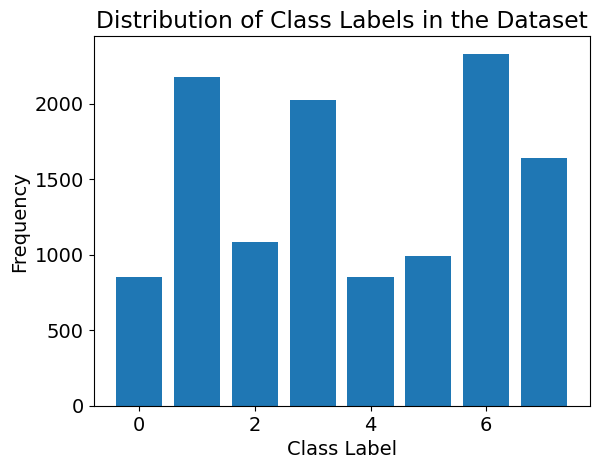

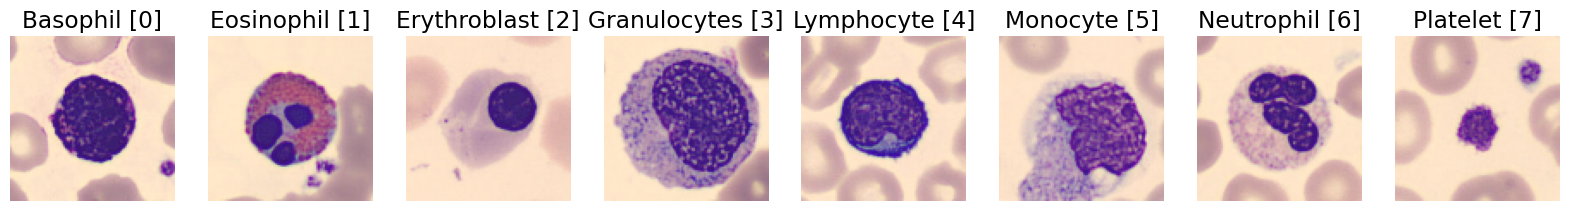

In [ ]:
# Print Distribution of Class Labels in the Dataset, to visualize it's inabalancement
labels_count = Counter(y.flatten())
plt.bar(labels_count.keys(), labels_count.values())
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Class Labels in the Dataset")
plt.show()

fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 15))

for i, label in enumerate(unique_labels):
    idx = np.where(y == label)[0][0]
    axes[i].imshow(X[idx])
    axes[i].set_title(labels[label] + ' [' + str(label) + ']')
    axes[i].axis('off')

plt.show()

## Apply Class Weights
for compensating the dataset imbalancement during training

In [ ]:
# Calculate Class Weights Based on the class distributions
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.ravel())
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 1.7575, 1: 0.6855782469022488, 2: 1.3768433179723503, 3: 0.7384453781512605, 4: 1.7595700824499412, 5: 1.505922379032258, 6: 0.6411480686695279, 7: 0.9092361533779671}


## Data Preprocessing
Split the dataset

In [ ]:
# Preprocessing data with normalization (/255) is no longer necessary when working with EfficientNetV2S
# X = (X / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=SEED)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (10755, 96, 96, 3)
Training Label Shape: (10755, 8)
Validation Data Shape: (1196, 96, 96, 3)
Validation Label Shape: (1196, 8)


Apply Augmentation (RandAugment and Augmix) and print some agumented images

In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.5
)

augmix = keras_cv.layers.AugMix(
    value_range=(0, 255),
    severity=0.3,
    num_chains=3,
    chain_depth=[1, 3],
)

train_dataset_augmented = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (rand_augment(augmix(tf.cast(x, tf.uint8))), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .prefetch(tf.data.AUTOTUNE)
    .unbatch()
)

In [ ]:
X_train_augmented = []
y_train_augmented = []

for element in train_dataset_augmented.as_numpy_iterator():
    X_train_augmented.append(element[0])
    y_train_augmented.append(element[1])

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

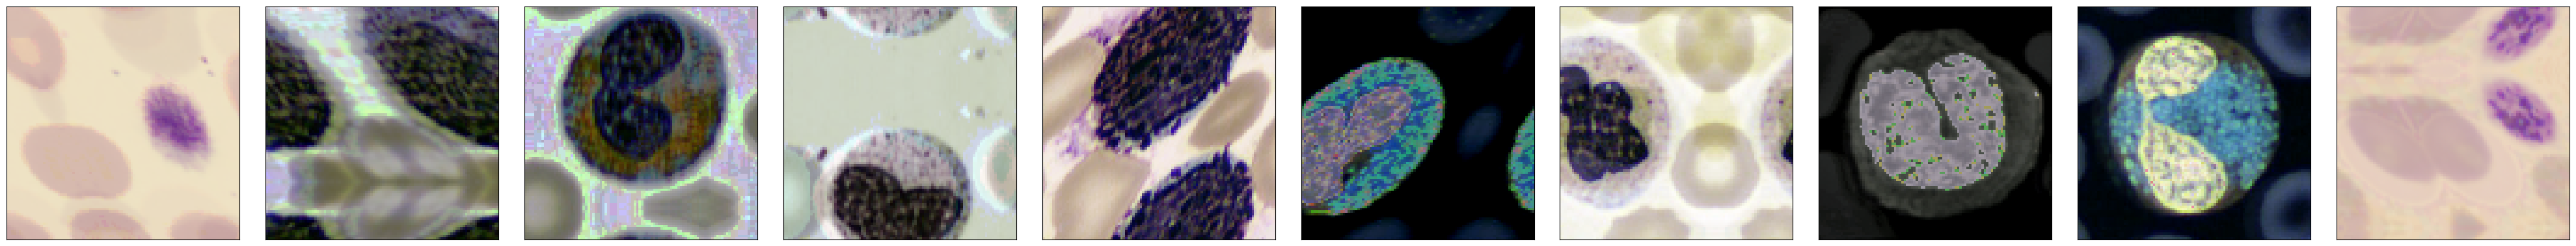

In [ ]:
img_to_show = 10
fig, axes = plt.subplots(1, img_to_show, figsize=(4 * img_to_show, 4))

# Display some random images for each class
for i in range(img_to_show):
    ax = axes[i]
    ax.imshow(X_train_augmented[i] / 255)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 🛠️ Build the Model and Apply Transfer Learning
We use a pre-trained CNN (model_supernet = EfficientNetV2S) as FEN, and we add some FCLs at the end of it. Then, keeping the FEN (model_supernet = EfficientNetV2S) frozen, we train the whole network.


In [ ]:
# Input shape for the model
input_shape = X_train_augmented.shape[1:]

# Output shape for the model
output_shape = y_train_augmented.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


Apply an augmentation layer with the best scoring pipeline reached so far

In [ ]:
augmentation_layer = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.35),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.1, value_range=(0,255)),
    tfkl.RandomContrast(0.2),
], name='augmentation')

Download the model to be used as a FEN


In [ ]:
# Model choosen as a FEN is EfficientNetV2S, we take the weights already trained on ImageNet dataset
model_supernet = tfk.applications.EfficientNetV2S(
    input_shape = input_shape,
    include_top = False,
    weights='imagenet',
)
model_supernet.trainable = False # FEN frozen

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Transfer-Learning model parameters

In [ ]:
# Number of training EPOCHS
EPOCHS = 1000

# Batch size for training
BATCH_SIZE = 64

# Learning rate: step size for updating the model's weights
LEARNING_RATE = 0.001

# Rate of the First Dropout layer
DROPOUT_RATE_FIRST=0.5

# Rate of the Other Dropout layers
DROPOUT_RATE_OTHERS=0.3

# L2 regularization
L2_LAMBDA = 0.001

In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    l2_lambda=L2_LAMBDA
):
    initializer = tfk.initializers.HeUniform(seed)
    regulariser = tfk.regularizers.l2(l2_lambda)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='input')

    x = augmentation_layer(inputs)

    x = model_supernet(x)
    x = tfkl.Flatten(name='flatten')(x)
    x = tfkl.Dropout(DROPOUT_RATE_FIRST)(x)

    x = tfkl.Dense(units=1024, kernel_initializer=initializer, kernel_regularizer=regulariser, name='dense1')(x)
    x = tfkl.Dropout(DROPOUT_RATE_OTHERS)(x)
    x = tfkl.Activation('relu', name='actdense1')(x)

    x = tfkl.Dense(units=1024, kernel_initializer=initializer, kernel_regularizer=regulariser, name='dense2')(x)
    x = tfkl.Dropout(DROPOUT_RATE_OTHERS)(x)
    x = tfkl.Activation('relu', name='actdense2')(x)

    x = tfkl.Dense(units=output_shape, kernel_regularizer=regulariser, name='output')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ augmentation (Sequential)           │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_4           │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom (RandomZoom)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_brightness_2            │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomBrightness)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_contrast_2              │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomContrast)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ efficientnetv2-s (Functional)       │ (None, 3, 3, 1280)           │    20,331,360 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ rescaling (Rescaling)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_conv (Conv2D)             │ (None, 48, 48, 24)           │           648 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_bn (BatchNormalization)   │ (None, 48, 48, 24)           │            96 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ stem_activation (Activation)   │ (None, 48, 48, 24)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_conv (Conv2D)  │ (None, 48, 48, 24)           │         5,184 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_bn             │ (None, 48, 48, 24)           │            96 │    N    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1a_project_activation     │ (None, 48, 48, 24)           │             0 │    -    │
│ (Activation)         

 Total params: 33,186,664 (126.60 MB)

 Trainable params: 12,855,304 (49.04 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

## 🛠️ Train and Save the Model

Use early stopping: ensuring the model stops training when validation accuracy stops improving for "patience" epochs, and the weights are restored to the best-performing epoch.

In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Change this variable to change the name of the .keras file
MODEL_NAME = 'EFFNETV2'

# Train the model with early stopping callback
history = model.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights_dict
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CNN_'+MODEL_NAME+'_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.2934 - loss: 5.9337 - val_accuracy: 0.6622 - val_loss: 3.0906
Epoch 2/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.4344 - loss: 3.3684 - val_accuracy: 0.6906 - val_loss: 2.1615
Epoch 3/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.4798 - loss: 2.6070 - val_accuracy: 0.7416 - val_loss: 1.7679
Epoch 4/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.4991 - loss: 2.2806 - val_accuracy: 0.7308 - val_loss: 1.5162
Epoch 5/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.5174 - loss: 2.0824 - val_accuracy: 0.7659 - val_loss: 1.3753
Epoch 6/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.5240 - loss: 1.9739 - val_accuracy: 0.7651 - val_loss: 1.3080
Epoch 7/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.5227 - loss: 1.9099 - val_accuracy: 0.6781 - val_loss: 1.4429
Epoch 8/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.5295 

In [ ]:
metadata[MODEL_NAME] = (
    round(history['accuracy'][-1] * 100, 2),
    round(max(history['val_accuracy']) * 100, 2),
    history
)

with open(METADATA_FILE, 'wb') as f:
    pickle.dump(metadata, f)

## Apply Fine Tuning

In [ ]:
TRANSFER_MODEL_NAME = model_filename
SUPERNET_NAME = 'efficientnetv2-s'

# Re-load the model after transfer learning
if IS_COLAB:
    ft_model = tfk.models.load_model(TRANSFER_MODEL_NAME)
else:
    ft_model = tfk.models.load_model('/kaggle/working/'+ TRANSFER_MODEL_NAME)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

print("Number of layers in the net: ", len(ft_model.layers))
print("Number of layers in the supernet: ", len(ft_model.get_layer(SUPERNET_NAME).layers))

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_4            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness_2             │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_2               │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 3, 3, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 58,897,274 (224.68 MB)

 Trainable params: 12,855,304 (49.04 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 25,710,610 (98.08 MB)

Number of layers in the net:  13
Number of layers in the supernet:  513


In [ ]:
# Set the supernet model layers as trainable
ft_model.get_layer(SUPERNET_NAME).trainable = True

# Set all supernet layers as non-trainable
for layer in ft_model.get_layer(SUPERNET_NAME).layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer(SUPERNET_NAME).layers):
    if isinstance(layer, tfk.layers.Conv2D) or isinstance(layer, tfk.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 stem_conv Conv2D True
5 block1a_project_conv Conv2D True
9 block1b_project_conv Conv2D True
14 block2a_expand_conv Conv2D True
17 block2a_project_conv Conv2D True
19 block2b_expand_conv Conv2D True
22 block2b_project_conv Conv2D True
26 block2c_expand_conv Conv2D True
29 block2c_project_conv Conv2D True
33 block2d_expand_conv Conv2D True
36 block2d_project_conv Conv2D True
40 block3a_expand_conv Conv2D True
43 block3a_project_conv Conv2D True
45 block3b_expand_conv Conv2D True
48 block3b_project_conv Conv2D True
52 block3c_expand_conv Conv2D True
55 block3c_project_conv Conv2D True
59 block3d_expand_conv Conv2D True
62 block3d_project_conv Conv2D True
66 block4a_expand_conv Conv2D True
69 block4a_dwconv2 DepthwiseConv2D True
74 block4a_se_reduce Conv2D True
75 block4a_se_expand Conv2D True
77 block4a_project_conv Conv2D True
79 block4b_expand_conv Conv2D True
82 block4b_dwconv2 DepthwiseConv2D True
87 block4b_se_reduce Conv2D True
88 block4b_se_expand Conv2D True
90 block4b_project_c

##Fine-Tuning model parameters

In [ ]:
# Number of layers freozen in the super net
FT_FREEZE_LAYERS = 0

#Apply a low learning rate for fine-tuning
FT_LEARNING_RATE = 5e-5

In [ ]:
# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer(SUPERNET_NAME).layers[:FT_FREEZE_LAYERS]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer(SUPERNET_NAME).layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

0 input_layer False
1 rescaling False
2 stem_conv True
3 stem_bn False
4 stem_activation False
5 block1a_project_conv True
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv True
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv True
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv True
18 block2a_project_bn False
19 block2b_expand_conv True
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv True
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv True
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv True
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv True
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv True
37 block2d_pro

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation (Sequential)            │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip (RandomFlip)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_4            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation                 │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom (RandomZoom)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness_2             │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_2               │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 3, 3, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 58,897,274 (224.68 MB)

 Trainable params: 32,878,920 (125.42 MB)

 Non-trainable params: 307,744 (1.17 MB)

 Optimizer params: 25,710,610 (98.08 MB)

In [ ]:
ft_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Adam(FT_LEARNING_RATE),
    metrics=['accuracy']
)

In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [ ]:
# Change this variable to change the name of the .keras file
FT_MODEL_NAME = 'FT_' + MODEL_NAME + '_freeze' + str(FT_FREEZE_LAYERS)

# Fine-tune the model
ft_history = ft_model.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights_dict
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
ft_model_filename = 'CNN_'+FT_MODEL_NAME+'_'+str(final_val_accuracy)+'.keras'
ft_model.save(ft_model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 91s 249ms/step - accuracy: 0.6044 - loss: 1.5059 - val_accuracy: 0.8988 - val_loss: 0.7133
Epoch 2/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 0.7317 - loss: 1.1668 - val_accuracy: 0.9247 - val_loss: 0.6310
Epoch 3/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.7820 - loss: 1.0213 - val_accuracy: 0.9457 - val_loss: 0.5671
Epoch 4/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.8046 - loss: 0.9339 - val_accuracy: 0.9314 - val_loss: 0.5886
Epoch 5/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.7991 - loss: 0.9691 - val_accuracy: 0.9440 - val_loss: 0.5573
Epoch 6/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 219ms/step - accuracy: 0.8271 - loss: 0.8494 - val_accuracy: 0.9657 - val_loss: 0.4646
Epoch 7/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.8453 - loss: 0.7812 - val_accuracy: 0.9674 - val_loss: 0.4438
Epoch 8/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 

In [ ]:
metadata[FT_MODEL_NAME] = (
    round(ft_history['accuracy'][-1] * 100, 2),
    round(max(ft_history['val_accuracy']) * 100, 2),
    ft_history
)

with open(METADATA_FILE, 'wb') as f:
    pickle.dump(metadata, f)

EFFNETV2 train accuracy: 55.47
EFFNETV2 validation accuracy: 78.34
FT_EFFNETV2_freeze0 train accuracy: 98.08
FT_EFFNETV2_freeze0 validation accuracy: 97.91


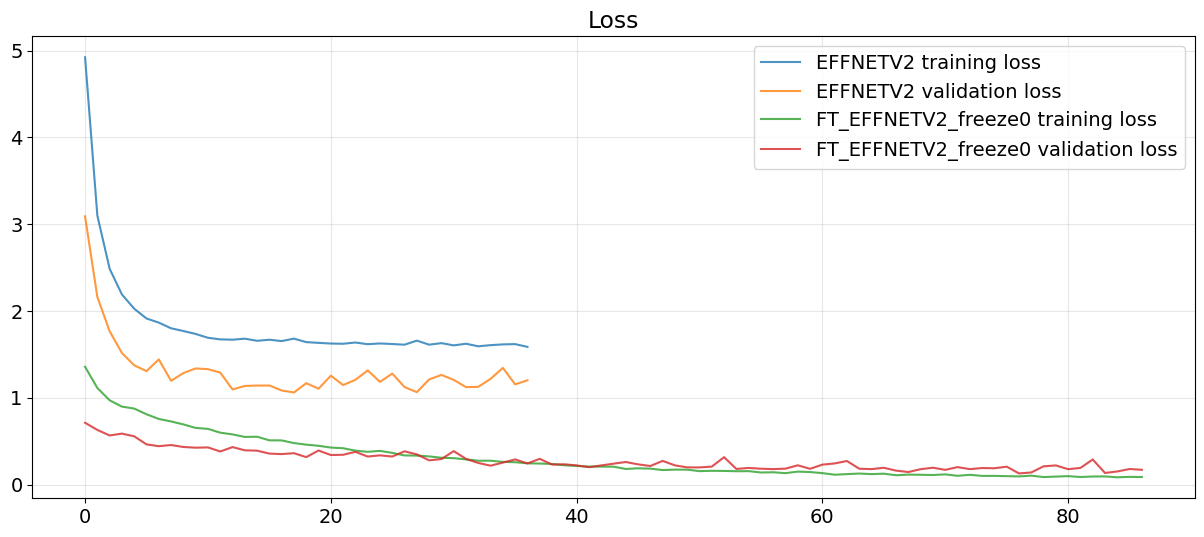

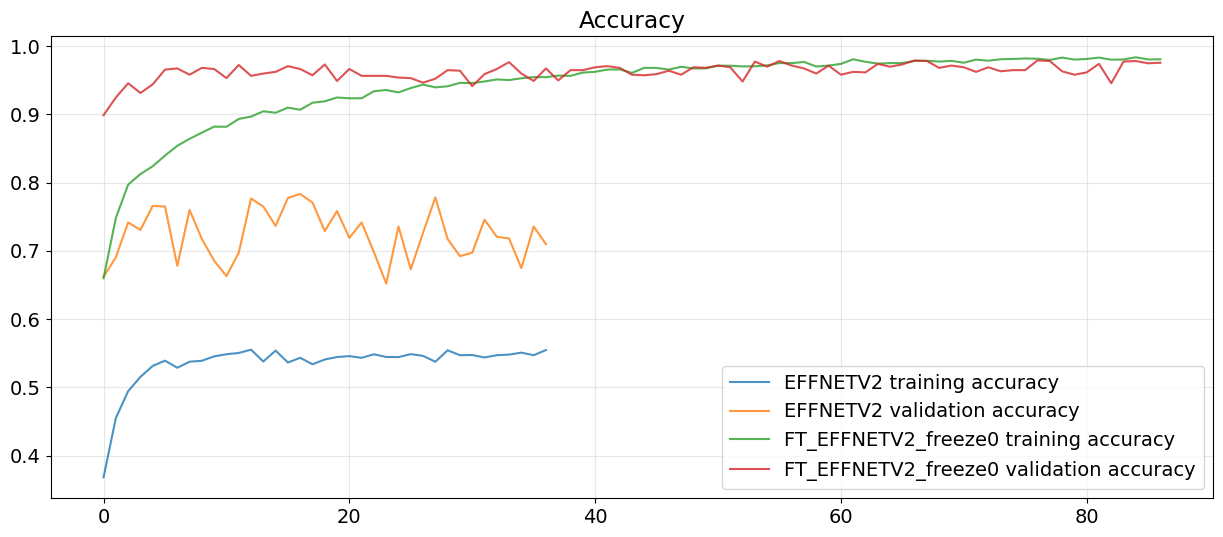

In [ ]:
start_epoch = 0

metadata_copy = metadata.copy()

for name, (acc, val_acc, _) in metadata_copy.items():
    print(name + " train accuracy:", acc)
    print(name + " validation accuracy:", val_acc)

# Plot training and validation loss
plt.figure(figsize=(15, 6))
for name, (_, _, saved_history) in metadata_copy.items():
    plt.plot(saved_history['loss'][start_epoch:], label=name+' training loss', alpha=.8)
    plt.plot(saved_history['val_loss'][start_epoch:], label=name+' validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 6))
for name, (_, _, saved_history) in metadata_copy.items():
    plt.plot(saved_history['accuracy'][start_epoch:], label=name+' training accuracy', alpha=.8)
    plt.plot(saved_history['val_accuracy'][start_epoch:], label=name+' validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)

plt.show()

## Confusion Matrixes
Here we perform a strong augmentation on the validation set to see if our model is able to make predictions on distorted images.
This was useful because the accuracy on the augmented validation set was closer to the Codabench test set.
Below we print the accuracy and confusion matrixes of, respectively, both the validation set (without augmentation) and validation set with augmentation

In [ ]:
test_augmentation_layer = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.4,0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomZoom(0.4),
    tfkl.RandomBrightness(0.7, value_range=(0,255)),
    tfkl.RandomContrast(0.85),
    tfkl.GaussianNoise(0.15)
], name='augmentation')

X_val_augmented = test_augmentation_layer(X_val)

In [ ]:
# Load the saved model
saved_model = tfk.models.load_model(ft_model_filename)

Predictions Shape: (1196, 8)
Accuracy score over the val set: 0.9791
Precision score over the val set: 0.9798
Recall score over the val set: 0.9791
F1 score over the val set: 0.9792


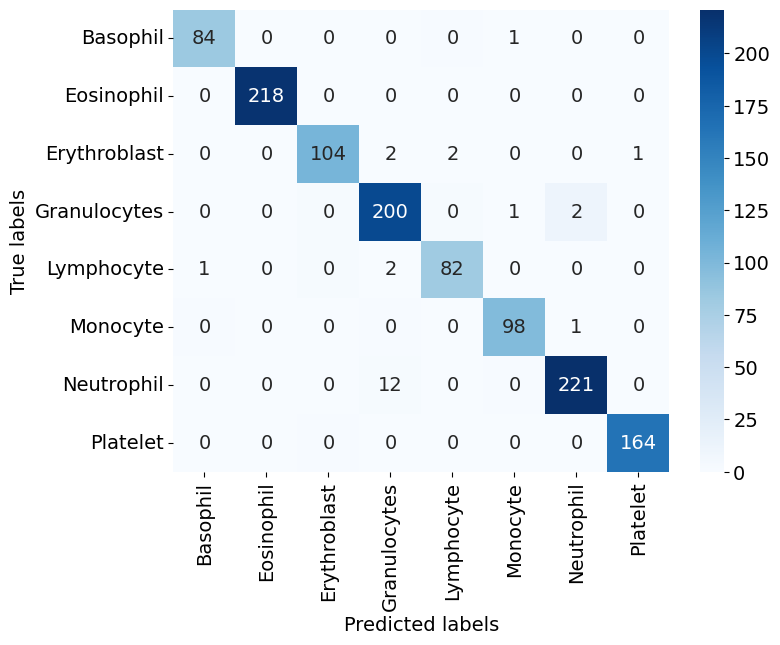

Predictions Shape: (1196, 8)
Accuracy score over the val set: 0.9038
Precision score over the val set: 0.9045
Recall score over the val set: 0.9038
F1 score over the val set: 0.904


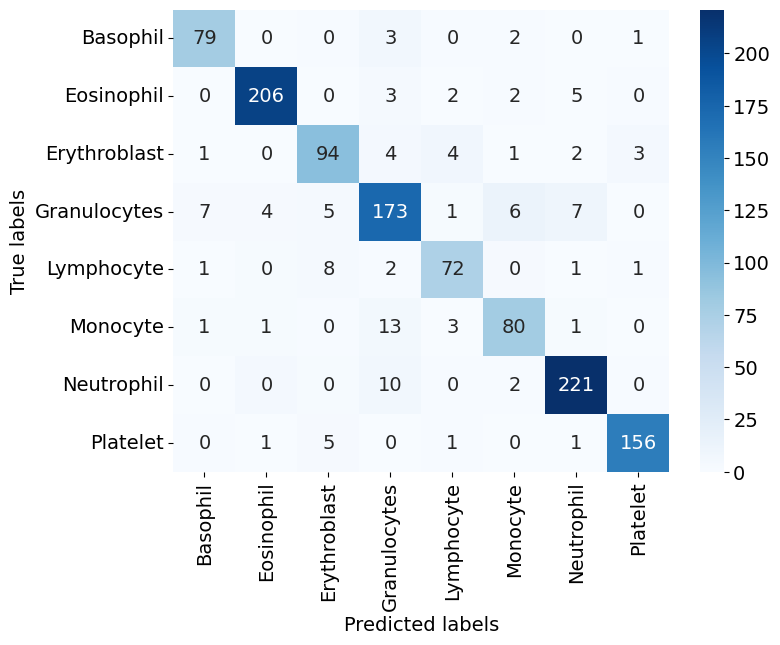

In [ ]:
for X_val_i in [X_val, X_val_augmented]:
    # Predict labels for the entire test set
    predictions = saved_model.predict(X_val_i, verbose=0)

    # Display the shape of the predictions
    print("Predictions Shape:", predictions.shape)

    # Convert predictions to class labels
    pred_classes = np.argmax(predictions, axis=-1)

    # Extract ground truth classes
    true_classes = np.argmax(y_val, axis=-1)

    # Calculate and display val set accuracy
    accuracy = accuracy_score(true_classes, pred_classes)
    print(f'Accuracy score over the val set: {round(accuracy, 4)}')

    # Calculate and display val set precision
    precision = precision_score(true_classes, pred_classes, average='weighted')
    print(f'Precision score over the val set: {round(precision, 4)}')

    # Calculate and display val set recall
    recall = recall_score(true_classes, pred_classes, average='weighted')
    print(f'Recall score over the val set: {round(recall, 4)}')

    # Calculate and display val set F1 score
    f1 = f1_score(true_classes, pred_classes, average='weighted')
    print(f'F1 score over the val set: {round(f1, 4)}')

    # Compute the confusion matrix
    cm = confusion_matrix(true_classes, pred_classes)

    # Combine numbers and percentages into a single string for annotation
    annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()